# Цели и задачи проекта.

В проекте применим несколько библиотек для погнозирования временных рядов, в частности будем предсказывать цены на акции компании Фейсбук.

Оценим качество предсказаний и определим лучшую библиотеку.

Данные возьмем с Yahoo finance за последниие 10 лет.

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных о Meta Platforms, Inc. (тикер: META)
ticker = 'META'
data = yf.download(ticker, start='2014-06-01', end='2024-06-01')

# Просмотр нескольких строк данных
print(data.tail())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close   
Date                                                                     
2024-05-24  467.619995  479.850006  466.299988  478.220001  478.220001  \
2024-05-28  476.579987  480.859985  474.839996  479.920013  479.920013   
2024-05-29  474.660004  479.850006  473.700012  474.359985  474.359985   
2024-05-30  471.670013  471.730011  464.709991  467.049988  467.049988   
2024-05-31  465.799988  469.119995  454.459991  466.829987  466.829987   

              Volume  
Date                  
2024-05-24  12012300  
2024-05-28  10175800  
2024-05-29   9226200  
2024-05-30  10735200  
2024-05-31  16919800  


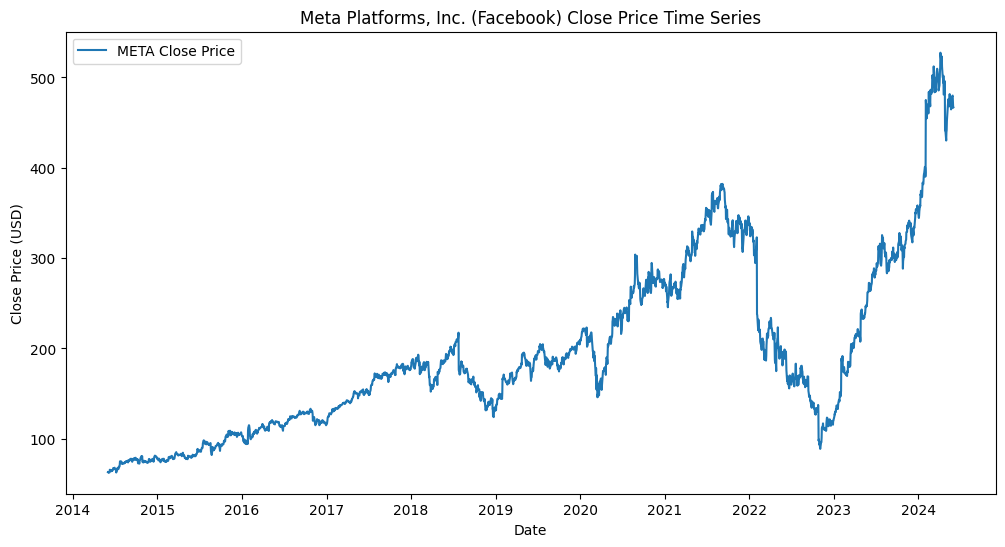

In [3]:
# Построение временного ряда цен закрытия
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='META Close Price')
plt.title('Meta Platforms, Inc. (Facebook) Close Price Time Series')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

Глядя на график можно сделать вывод, что временной ряд имеет выраженный тренд.

Подготовка данных для Prophet:

Prophet требует, чтобы данные были в определенном формате: дата должна называться ds, а значение — y.

In [4]:
# Подготовка данных
df_meta = data.reset_index()[['Date', 'Close']]
df_meta.columns = ['ds', 'y']

# Просмотр первых нескольких строк подготовленных данных
print(df_meta.head())

          ds          y
0 2014-06-02  63.080002
1 2014-06-03  62.869999
2 2014-06-04  63.340000
3 2014-06-05  63.189999
4 2014-06-06  62.500000


In [5]:
from prophet import Prophet

predictions = 30

# отрезаем из обучающей выборки последние 30 точек, чтобы измерить на них качество
train_df = df_meta[:-predictions]
test_df = df_meta[-predictions:]

# Шаг 2: Обучение модели Prophet на обучающей выборке
model = Prophet()
model.fit(train_df)

# Шаг 3: Прогнозирование на тестовой выборке
future = model.make_future_dataframe(periods=predictions)
forecast = model.predict(future)

13:37:24 - cmdstanpy - INFO - Chain [1] start processing
13:37:25 - cmdstanpy - INFO - Chain [1] done processing


В библиотеке Prophet есть встроенные средства визуализации, которые позволяют оценить результат построенной модели.

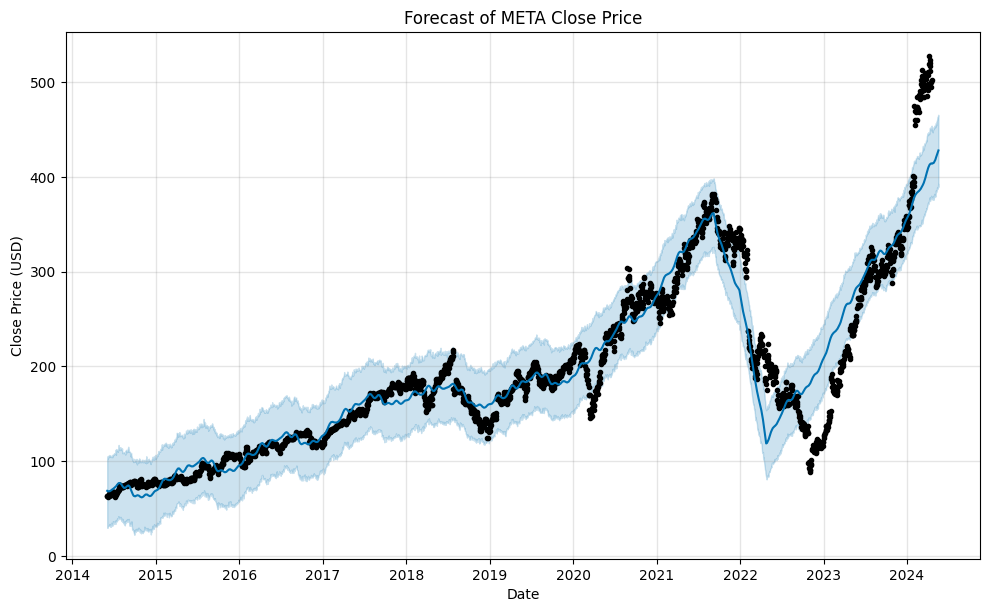

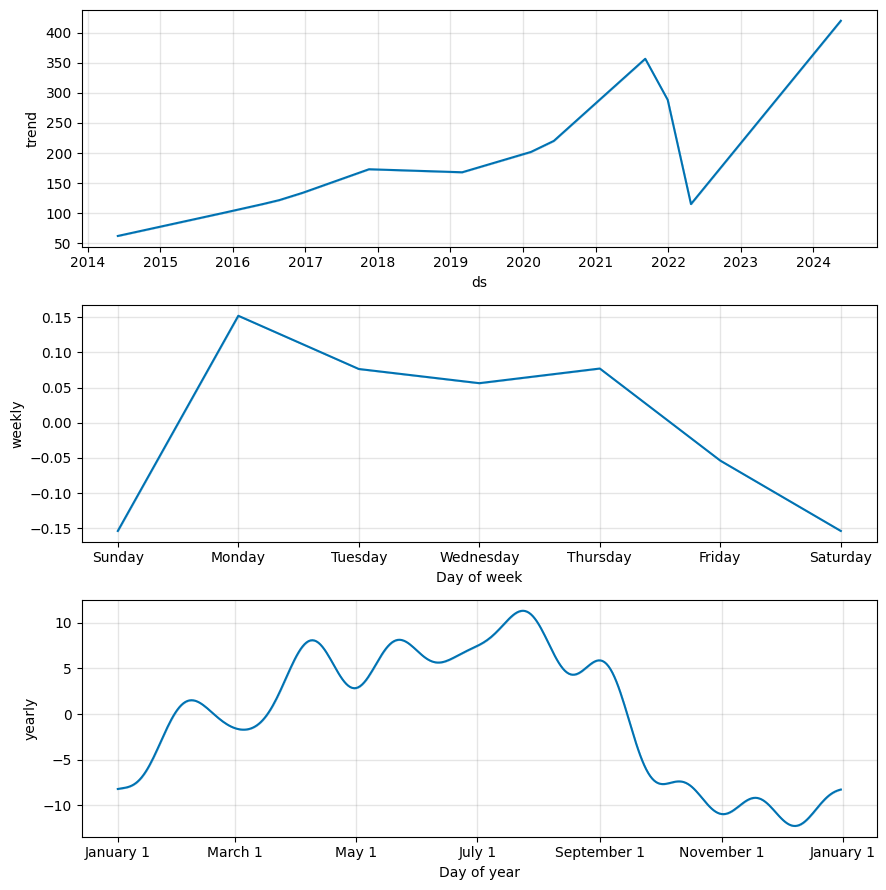

In [6]:
# Визуализация прогноза
fig1 = model.plot(forecast)
plt.title('Forecast of META Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.show()

# Визуализация компонент прогноза
fig2 = model.plot_components(forecast)
plt.show()

Из первого графика мало что можно сказать. Более интересны следующие графики.

На графике тренда видно, что Prophet хорошо подстроился под тренд до и после ковида. По недельной сезонности можно сделать вывод, что в суботу и воскресенье торгов естественно нет, биржы закрыты. На графике годовой сезонности ярче всего выделяется спад к концу года.

Давайте оценим качество алгоритма для последних 30 дней, которые мы предсказывали.

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Извлечение предсказанных значений для тестовой выборки
forecast_test = forecast[-predictions:]

# Шаг 4: Оценка качества предсказания
y_true = test_df['y'].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')

MAE: 47.48340442127953
MSE: 2507.915082998693


MAE: 47.48 — Это означает, что в среднем предсказанные значения отклоняются от фактических значений на 47.48 долларов. При цене 400 - 500 долларов за акцию ошибка на мой взгляд существенная.

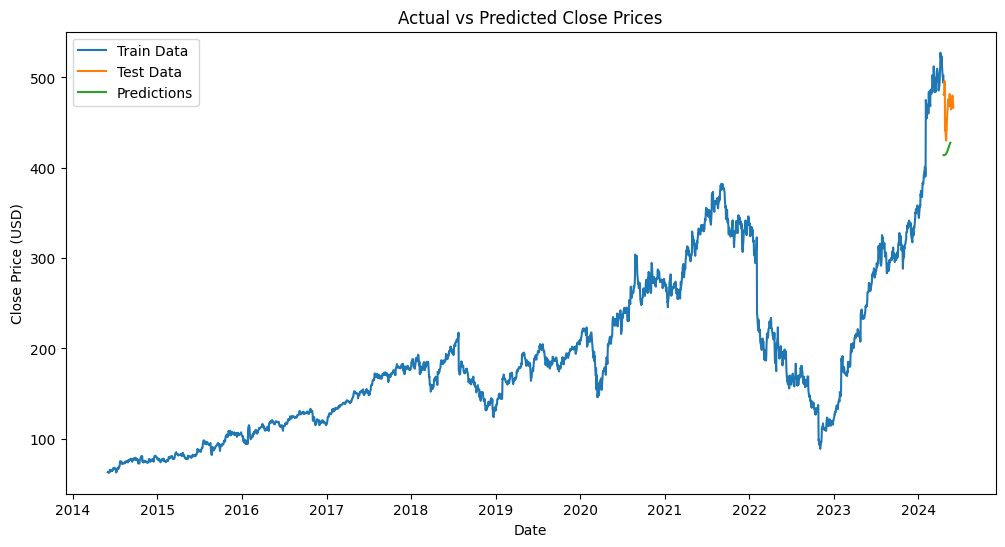

In [8]:
# Визуализация фактических значений и предсказаний
plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'], train_df['y'], label='Train Data')
plt.plot(test_df['ds'], test_df['y'], label='Test Data')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.show()

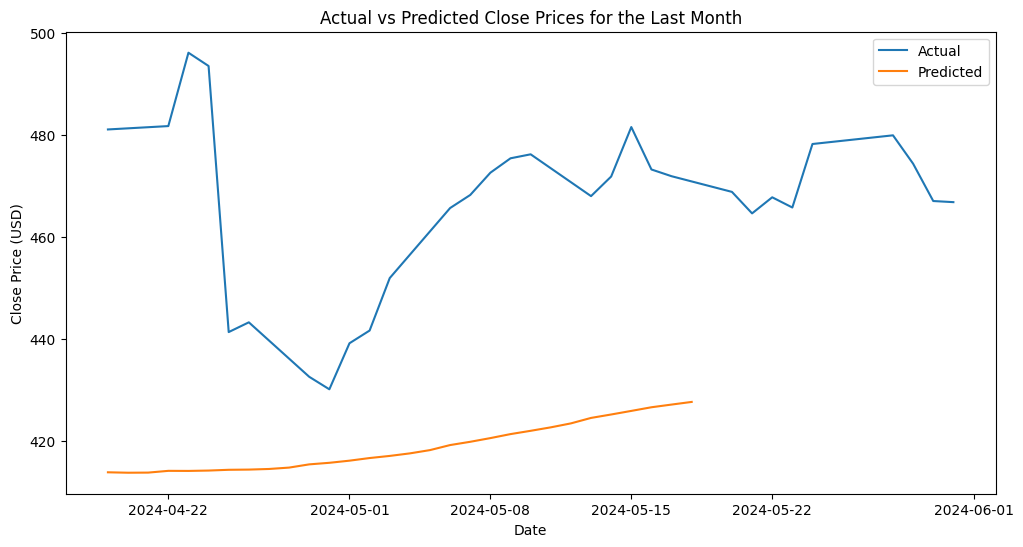

In [9]:
# Визуализация фактических значений и предсказаний только для последнего месяца
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], y_true, label='Actual')
plt.plot(forecast_test['ds'], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Actual vs Predicted Close Prices for the Last Month')
plt.legend()
plt.show()

LSTM (Long Short-Term Memory) - это тип рекуррентной нейронной сети (RNN), которая специально разработана для решения проблемы исчезающего градиента, распространенной в традиционных RNN. LSTM способна улавливать долгосрочные зависимости в данных и часто используется для анализа временных рядов и последовательных данных.

Основные компоненты LSTM

LSTM состоит из ячеек памяти, которые могут сохранять информацию на длительные периоды времени. Основные компоненты LSTM включают:

Ячейка памяти (Cell State):

- Основной компонент, через который проходит информация. Ячейка памяти может хранить данные на протяжении долгого времени.

Забывающий слой (Forget Gate):

- Определяет, какая информация из ячейки памяти должна быть забыта. Этот слой использует сигмоидную активацию, чтобы дать значение от 0 (полностью забыть) до 1 (полностью сохранить).

Входной слой (Input Gate):

- Решает, какая новая информация будет добавлена в ячейку памяти. Этот слой также использует сигмоидную активацию.

Слой обновления (Cell State Update):

- Обновляет состояние ячейки памяти на основе входной информации и предыдущего состояния.

Выходной слой (Output Gate):

- Решает, какая часть информации из ячейки памяти будет использована для вывода. Этот слой комбинирует состояние ячейки и выходной активации.

Сравним результаты с LSTM

In [10]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [16]:
# Загрузка данных о Meta Platforms, Inc. (тикер: META)
ticker = 'META'
data_ltsm = yf.download(ticker, start='2014-06-01', end='2024-06-01')
data_ltsm.reset_index(inplace=True)

# Подготовка данных
df = data_ltsm[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Преобразование данных в формат numpy
dataset = df[['y']].values

[*********************100%%**********************]  1 of 1 completed


In [17]:
import numpy as np
# Масштабирование данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Параметры для LSTM
time_step = 100
predictions = 30

# Разделение данных на обучающую и тестовую выборки
train_data = scaled_data[:-predictions]
test_data = scaled_data[-predictions-time_step:]

# Создание данных для LSTM
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Изменение формы данных для LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Создание модели LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Прогнозирование
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Обратное масштабирование данных
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

c:\Users\Андрей\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2388/2388 ━━━━━━━━━━━━━━━━━━━━ 77s 31ms/step - loss: 0.0020
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


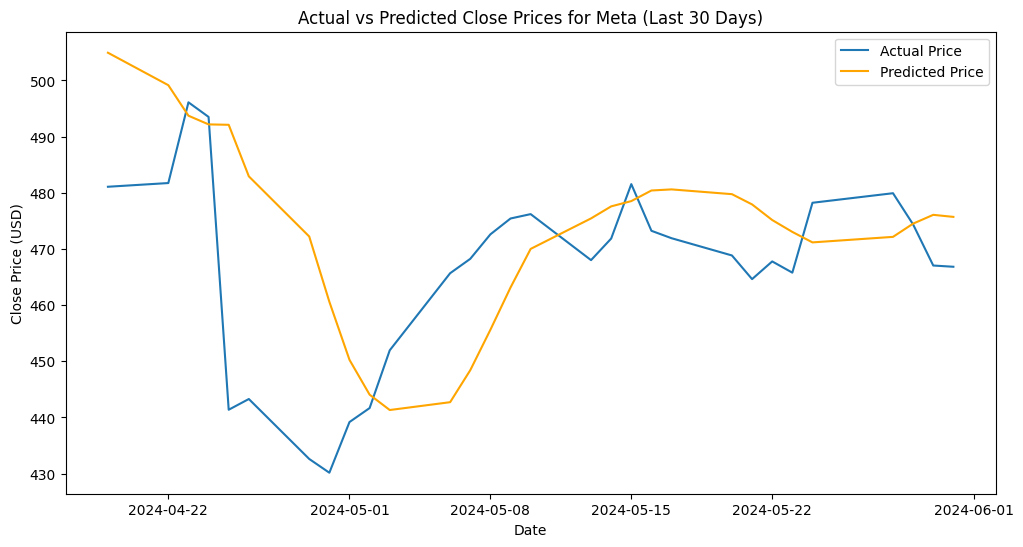

In [18]:
# Визуализация
plt.figure(figsize=(12, 6))

# График актуальной и предсказанной цены для тестового периода
plt.plot(df['ds'].iloc[-predictions:], y_test[0], label='Actual Price')
plt.plot(df['ds'].iloc[-predictions:], test_predict, label='Predicted Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Actual vs Predicted Close Prices for Meta (Last 30 Days)')
plt.legend()
plt.show()

Вывод: LTSM гораздо лучше уловила зависимость и предсказала цены на акцию!

In [19]:
# Оценка качества LSTM
mse_lstm = mean_squared_error(y_test[0], test_predict)
mae_lstm = mean_absolute_error(y_test[0], test_predict)
print(f"LSTM MSE: {mse_lstm}")
print(f"LSTM MAE: {mae_lstm}")

LSTM MSE: 335.1107608544944
LSTM MAE: 13.714491780598946


Метрики качества подтверждают наш вывод основанный на графике. MAE: 13.7 против MAE: 47.48 у Пророка. Достойны результат.

In [20]:
# Сохранение модели
model.save('lstm_stock_model.h5')

И последняя модель, которую мы применим для прогнозирования цен акций Фейсбука это ARIMA.

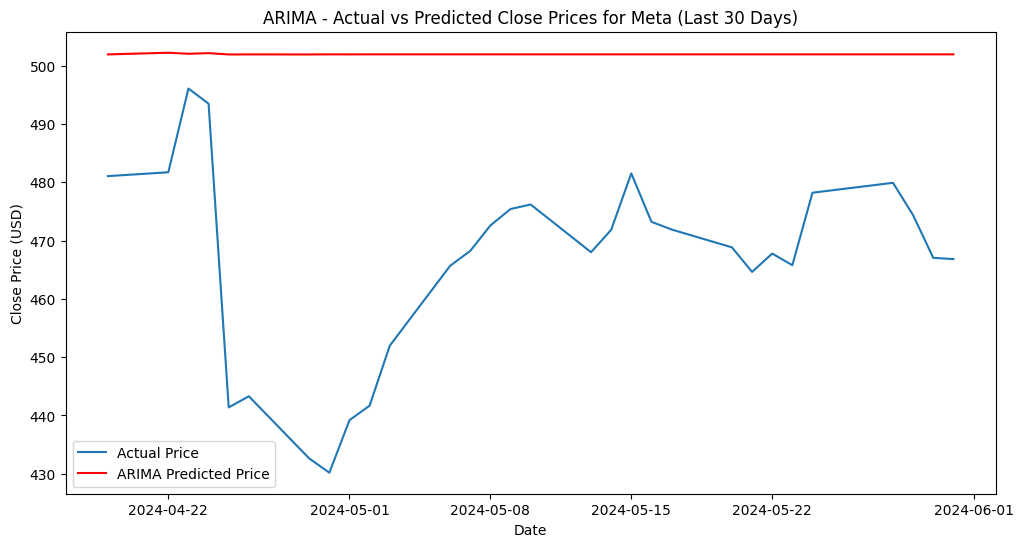

In [34]:
from statsmodels.tsa.arima.model import ARIMA
# Подготовка данных
train_data_arima = df['y'][:-predictions]
test_data_arima = df['y'][-predictions:]

# Обучение модели ARIMA
model_arima = ARIMA(train_data_arima, order=(5, 1, 0))
model_arima_fit = model_arima.fit()

# Прогнозирование
forecast_arima = model_arima_fit.forecast(steps=predictions)

# Визуализация прогноза ARIMA
plt.figure(figsize=(12, 6))
plt.plot(df['ds'].iloc[-predictions:], test_data_arima, label='Actual Price')
plt.plot(df['ds'].iloc[-predictions:], forecast_arima, label='ARIMA Predicted Price', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('ARIMA - Actual vs Predicted Close Prices for Meta (Last 30 Days)')
plt.legend()
plt.show()

In [35]:
# Оценка качества ARIMA
mse_arima = mean_squared_error(test_data_arima, forecast_arima)
mae_arima = mean_absolute_error(test_data_arima, forecast_arima)
print(f"ARIMA MSE: {mse_arima}")
print(f"ARIMA MAE: {mae_arima}")

ARIMA MSE: 1541.2309943042303
ARIMA MAE: 35.62242318348008


Судя по метрикам ARIMA справилась с прогнозом лучше чем Prophet, но обе модели сильно уступают LSTM.

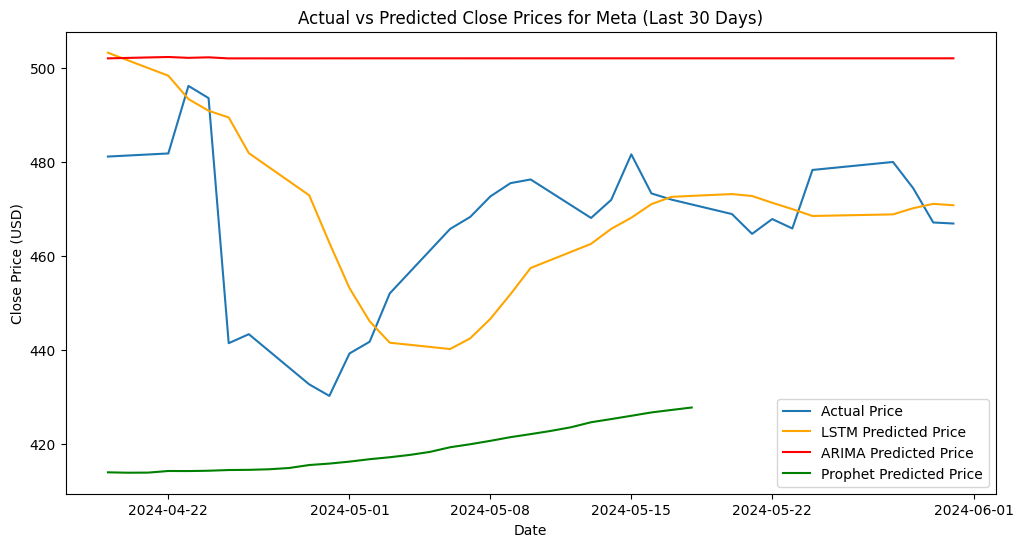

In [37]:
# Объединенная оценка и визуализация
plt.figure(figsize=(12, 6))
plt.plot(df['ds'].iloc[-predictions:], y_test[0], label='Actual Price')
plt.plot(df['ds'].iloc[-predictions:], test_predict, label='LSTM Predicted Price', color='orange')
plt.plot(df['ds'].iloc[-predictions:], forecast_arima, label='ARIMA Predicted Price', color='red')
plt.plot(forecast_test['ds'], y_pred, label='Prophet Predicted Price', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Actual vs Predicted Close Prices for Meta (Last 30 Days)')
plt.legend()
plt.show()

График совершенно наглядно показывает превосходство LTSM. Мы нашли модель которую можно использовать для предсказания цен на акции.

## Создание API для предсказаний

Используем Flask для создания веб-сервиса API, который будет принимать запросы и возвращать предсказания нашей модели LTSM:

In [24]:
from flask import Flask, request, jsonify
import numpy as np
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import pandas as pd

app = Flask(__name__)

# Загрузка модели и скейлера
model = load_model('lstm_stock_model.h5')
scaler = MinMaxScaler(feature_range=(0, 1))

def prepare_data(ticker, start, end, time_step=100):
    data = yf.download(ticker, start=start, end=end)
    df = data[['Close']].rename(columns={'Close': 'y'})
    dataset = df.values
    scaled_data = scaler.fit_transform(dataset)
    X_data = []
    for i in range(time_step, len(scaled_data)):
        X_data.append(scaled_data[i-time_step:i, 0])
    return np.array(X_data), scaler.inverse_transform(scaled_data)

@app.route('/predict', methods=['GET'])
def predict():
    ticker = request.args.get('ticker')
    start_date = request.args.get('start_date')
    end_date = request.args.get('end_date')
    predictions = int(request.args.get('predictions', 30))
    
    X_data, _ = prepare_data(ticker, start_date, end_date)
    X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
    
    predicted_prices = model.predict(X_data[-predictions:])
    predicted_prices = scaler.inverse_transform(predicted_prices)
    
    results = {"predictions": predicted_prices.flatten().tolist()}
    return jsonify(results)

if __name__ == '__main__':
    app.run(debug=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


После создания API, мы можем интегрировать его с фронтенд-приложением или другими системами. Например, можно создать простую веб-страницу, которая будет отправлять запросы к API и отображать результаты.